<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-CHAID:-Non-binary-decision-tree" data-toc-modified-id="1.-CHAID:-Non-binary-decision-tree-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. CHAID: Non-binary decision tree</a></span></li><li><span><a href="#2.-Stratyfing-our-train-population-for-better-representation-of-the-&quot;1s&quot;-and-applying-a-misclassification-cost" data-toc-modified-id="2.-Stratyfing-our-train-population-for-better-representation-of-the-&quot;1s&quot;-and-applying-a-misclassification-cost-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Stratyfing our train population for better representation of the "1s" and applying a misclassification cost</a></span></li><li><span><a href="#3.-Random-Forest-Tree-+-hyperparameters-optimization" data-toc-modified-id="3.-Random-Forest-Tree-+-hyperparameters-optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Random Forest Tree + hyperparameters optimization</a></span></li><li><span><a href="#Support-Vector-Mashine" data-toc-modified-id="Support-Vector-Mashine-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Support Vector Mashine</a></span></li><li><span><a href="#NGBoost" data-toc-modified-id="NGBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NGBoost</a></span></li><li><span><a href="#6.-Logistic-regression" data-toc-modified-id="6.-Logistic-regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>6. Logistic regression</a></span></li></ul></div>

# 1. CHAID: Non-binary decision tree 

In [105]:
from chefboost import Chefboost as chef


In [106]:
import pandas as pd

df = pd.read_csv("SC_data_new.csv")
config = {'algorithm': 'C4.5'}
model = chef.fit(df, config = config, target_label = 'default_flag')

[INFO]:  6 CPU cores will be allocated in parallel running
That's why, the algorithm is set to Regression to handle the data set.
Regression  tree is going to be built...


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv("SC_data_new.csv")
config = {'algorithm': 'CHAID'}
tree = chef.fit(df, config = config, target_label = 'default_flag')

# 2. Stratyfing our train population for better representation of the "1s" and applying a misclassification cost

In [107]:
%reset -f
%precision 3

'%.3f'

In [108]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline
plt.style.use("ggplot")

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [109]:
import warnings

warnings.filterwarnings('ignore')

In [110]:
data = 'SC_data_new.csv'

df = pd.read_csv(data)


In [111]:
#EXPERIMENTAL DROPPING THE COLUMNS THAT WE DONT LIKE 

df=df.drop(['FIRST_MOB'], axis=1)
df.shape


(169713, 92)

In [112]:
df.head()
df['default_flag'].value_counts()

0    168757
1       956
Name: default_flag, dtype: int64

In [113]:
y = df['default_flag']

In [114]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 0)

In [115]:
df_data=X_train
strat1 = df_data.loc[df_data['default_flag']==1] # Calculate the number of rows to match the desired proportion

temp0 = df_data.loc[df_data['default_flag']==0]
strat0=temp0.sample(frac=0.05, random_state=0)

X_strat = pd.concat([strat1, strat1, strat1, strat0]) 
y_strat = X_strat['default_flag']
X_strat.shape


(9030, 92)

In [116]:
strat0.shape

(6750, 92)

In [117]:
#X_train = X_train.drop(['default_flag', 'FIRST_MOB'], axis=1)
X_train_tmp=X_train.drop(['default_flag'], axis=1)
y_train_tmp = X_train['default_flag']

X_strat = X_strat.drop(['default_flag'], axis=1)
X_test = X_test.drop(['default_flag'], axis=1)

In [118]:
X_train=X_strat
y_train=y_strat

In [119]:
X_train.shape, X_test.shape

((9030, 91), (33943, 91))

In [120]:
# check data types in X_train

X_train.dtypes

id                                     int64
ACC_ST_A_Dt_SUM                      float64
working_months_new                     int64
POSIT_INT_INST_MIN                   float64
TRX_CH_CD_PAYMENT_ORDER_MIN3         float64
                                      ...   
CURR_CD_OTH_MAX12                    float64
CNT_ACC_ONE_CUST_CH_12               float64
TRX_CH_CD_PAYMENT_ORDER_CNT_CH_12    float64
TRX_CH_CD_E_CHANNEL_MIN_CH_6         float64
Miscellaneous Stores_MIN_CH_6        float64
Length: 91, dtype: object

In [121]:
from sklearn.tree import DecisionTreeClassifier

In [122]:
# instantiate the DecisionTreeClassifier model with criterion gini index according to the optimized paramethers

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=50,  min_samples_leaf=10, random_state=0)


clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, random_state=0)

In [123]:
#setting a threshold for the cut off/misclassification costs 

y_pred_gini = (clf_gini.predict_proba(X_test)[:,1] >= 0.005).astype(bool)

(array([26275.,     0.,    92.,   369.,   406.,  1531.,   381.,   354.,
          502.,   569.,   643.,   107.,   495.,   483.,    94.,   677.,
          965.]),
 array([0.   , 0.059, 0.118, 0.176, 0.235, 0.294, 0.353, 0.412, 0.471,
        0.529, 0.588, 0.647, 0.706, 0.765, 0.824, 0.882, 0.941, 1.   ]),
 <BarContainer object of 17 artists>)

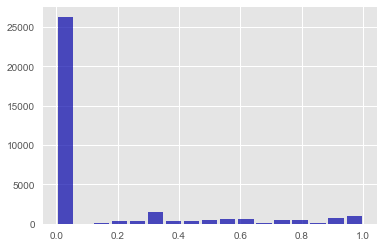

In [124]:
zzz=clf_gini.predict_proba(X_test)[:,1]
plt.hist(x=zzz, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)


In [125]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.7746


In [126]:
y_pred_train_gini = (clf_gini.predict_proba(X_train)[:,1] >= 0.005).astype(bool)
y_pred_train_gini

array([ True,  True,  True, ..., False, False, False])

In [127]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.8761


In [128]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.9147
Test set score: 0.8799


In [129]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_gini)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[26185  7562]
 [   90   106]]


In [130]:
y_pred_train_tmp = clf_gini.predict(X_train_tmp)

cm_train = confusion_matrix(y_train_tmp, y_pred_train_tmp)

print('Confusion matrix\n\n', cm_train)

Confusion matrix

 [[119803  15207]
 [   126    634]]


In [131]:

cm_train = confusion_matrix(y_train, y_pred_train_gini)

print('Confusion matrix\n\n', cm_train)

Confusion matrix

 [[5631 1119]
 [   0 2280]]


[Text(0.43462367657103823, 0.975, 'X[2] <= 90.0\ngini = 0.377\nsamples = 9030\nvalue = [6750, 2280]'),
 Text(0.15052937158469945, 0.925, 'X[83] <= -0.207\ngini = 0.49\nsamples = 2111\nvalue = [1205, 906]'),
 Text(0.07791154371584699, 0.875, 'X[68] <= 53.5\ngini = 0.489\nsamples = 956\nvalue = [407, 549]'),
 Text(0.03551912568306011, 0.825, 'X[7] <= -0.806\ngini = 0.496\nsamples = 369\nvalue = [201, 168]'),
 Text(0.017759562841530054, 0.775, 'X[50] <= -0.81\ngini = 0.477\nsamples = 143\nvalue = [56, 87]'),
 Text(0.00819672131147541, 0.725, 'X[4] <= -0.111\ngini = 0.346\nsamples = 81\nvalue = [18, 63]'),
 Text(0.00546448087431694, 0.675, 'gini = 0.497\nsamples = 13\nvalue = [7, 6]'),
 Text(0.01092896174863388, 0.675, 'X[0] <= 46655.0\ngini = 0.271\nsamples = 68\nvalue = [11, 57]'),
 Text(0.00546448087431694, 0.625, 'X[61] <= -0.69\ngini = 0.454\nsamples = 23\nvalue = [8, 15]'),
 Text(0.00273224043715847, 0.575, 'gini = 0.142\nsamples = 13\nvalue = [1, 12]'),
 Text(0.00819672131147541, 0.

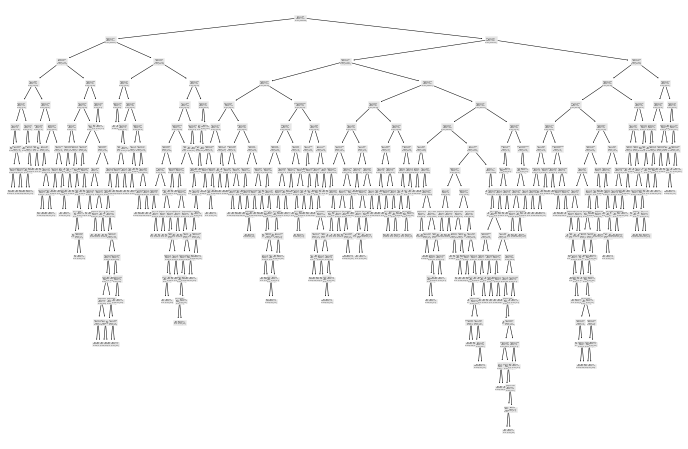

In [81]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train)) 


In [82]:
import graphviz

dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=None,  
                              filled=True, rounded=True,  
                              special_characters=True)



graph = graphviz.Source(dot_data)

graph.render('dtree_render_example_better',view=True)



'dtree_render_example_better.pdf'

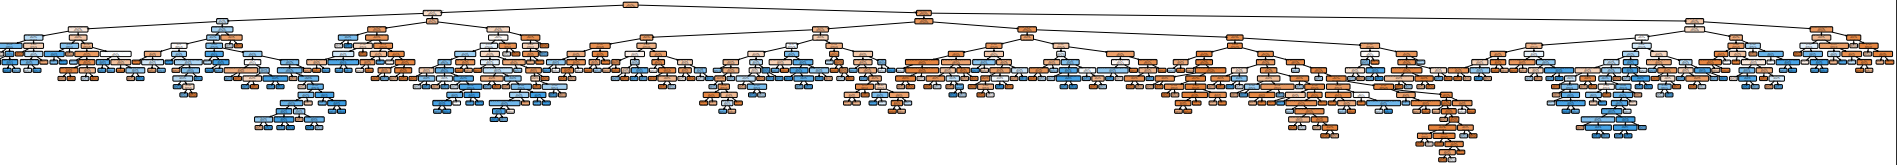

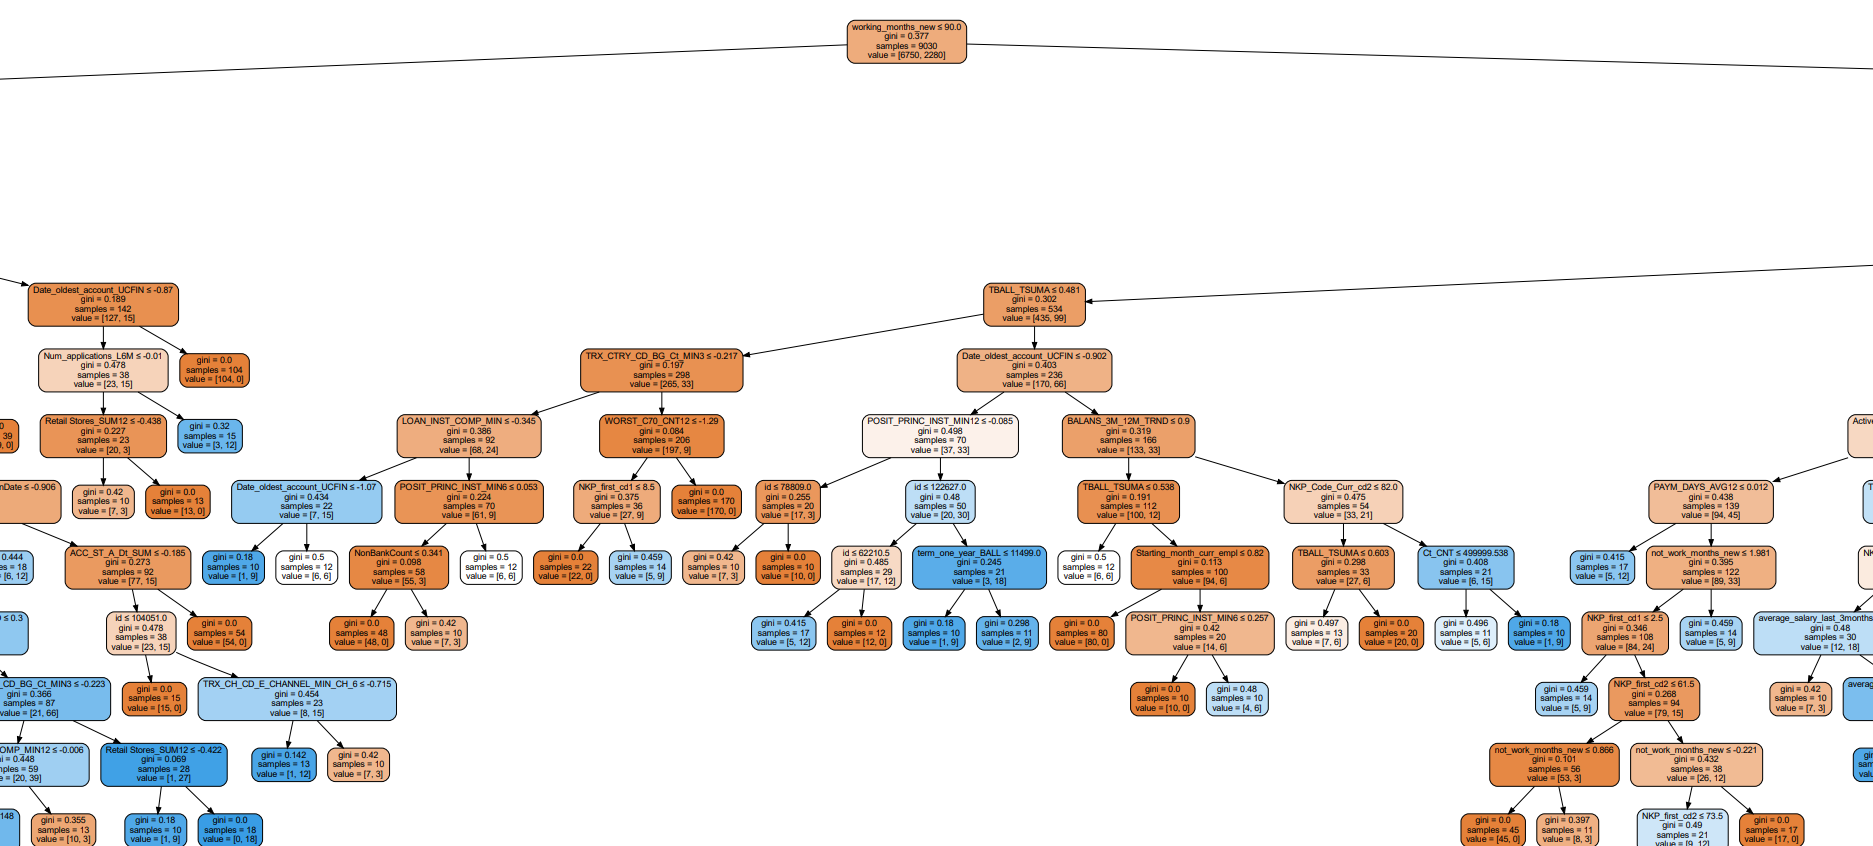

We've got some colors!

# 3. Random Forest Tree + hyperparameters optimization

In [132]:

from sklearn.ensemble import RandomForestClassifier

In [133]:
# instantiate the DecisionTreeClassifier model with criterion gini index

clf = RandomForestClassifier(n_jobs=-1)
#DecisionTreeClassifier(criterion='gini', n_jobs=-1)
   # (criterion='gini', max_depth=50, min_samples_leaf=20, random_state=0)

param_grid = {
    'criterion': ['gini'],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 10, 15, 25, 35, 50],
    'max_features': [10, 20, 30],
        
    
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



In [134]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    
    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

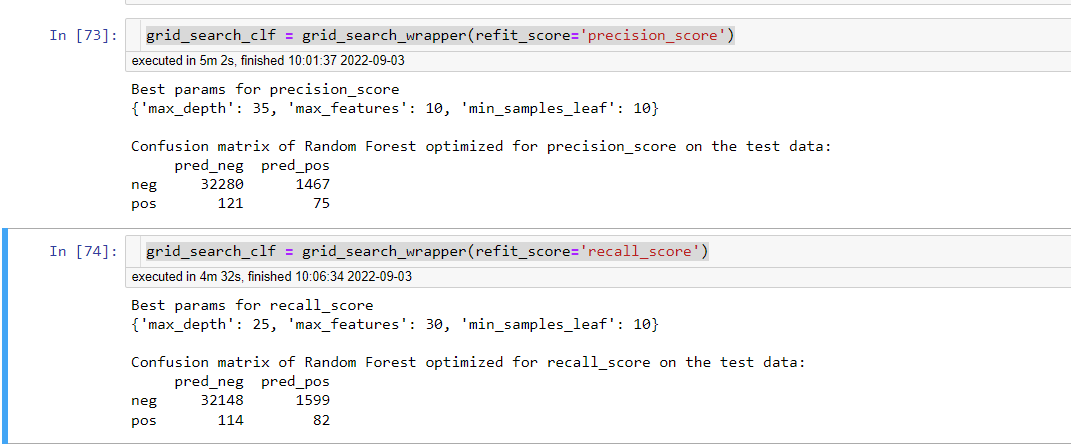

Better results, but Random Forest is a black box method => not a solution.
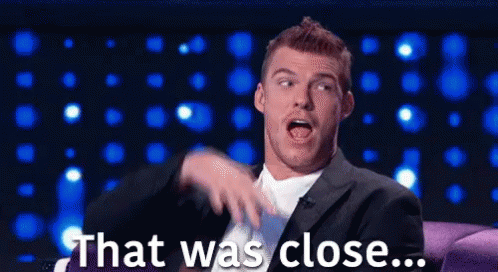

# 3.Support Vector Mashine

Support Vector Machines (SVMs in short) are machine learning algorithms that are used for classification and regression purposes. SVMs are one of the powerful machine learning algorithms for classification, regression and outlier detection purposes. An SVM classifier builds a model that assigns new data points to one of the given categories. Thus, it can be viewed as a non-probabilistic binary linear classifier.

SVMs can be used for linear classification purposes. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using the kernel trick. It enable us to implicitly map the inputs into high dimensional feature spaces.

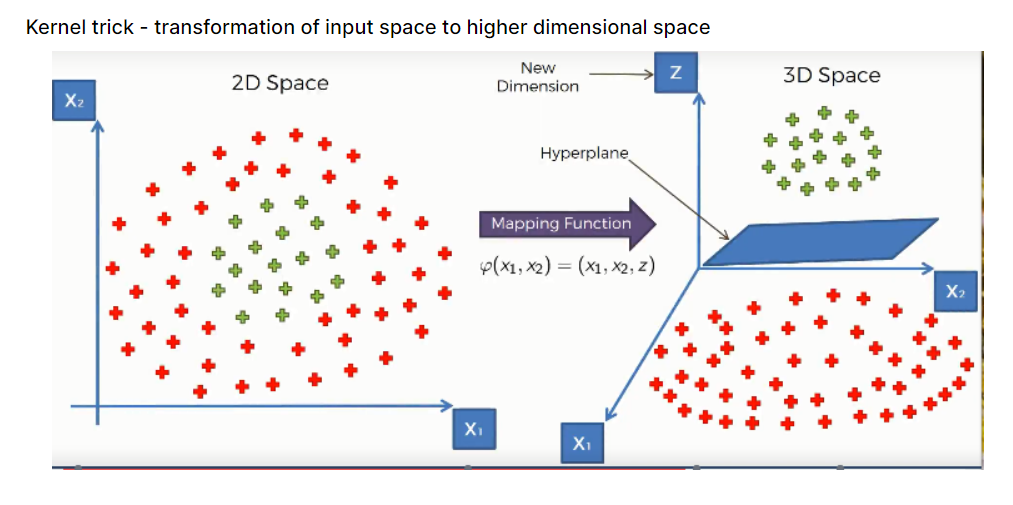

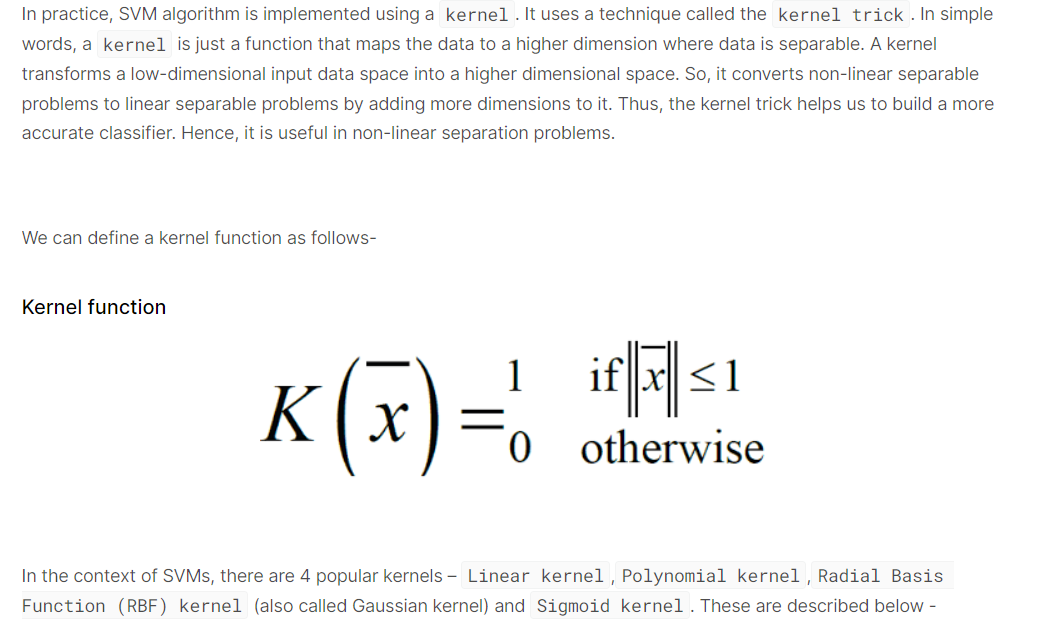

In [ ]:
%reset -f
%precision 3

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline


In [ ]:
data = 'SC_data_new.csv'

df = pd.read_csv(data)

df.shape

In [ ]:
col_names = df.columns

df.columns = df.columns.str.strip()

df.columns

df['default_flag'].value_counts()

df.info()

In [ ]:
df['default_flag'].value_counts()/np.float(len(df))
df=df.drop(['FIRST_MOB'], axis=1)
round(df.describe(),2)

In [ ]:
# draw boxplots to visualize outliers

plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='working_months_new')
fig.set_title('')
fig.set_ylabel('working_months_new')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='ACC_ONE_CUST_CNT12')
fig.set_title('')
fig.set_ylabel('ACC_ONE_CUST_CNT12')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='NKP_first_cd2')
fig.set_title('')
fig.set_ylabel('NKP_first_cd2')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='average_salary_last_3months')
fig.set_title('')
fig.set_ylabel('average_salary_last_3months')


plt.subplot(4, 2, 5)
fig = df.boxplot(column='BALANS_3M_12M_TRND')
fig.set_title('')
fig.set_ylabel('BALANS_3M_12M_TRND')


plt.subplot(4, 2, 6)
fig = df.boxplot(column='STAT1PROV_CNT12')
fig.set_title('')
fig.set_ylabel('STAT1PROV_CNT12')


plt.subplot(4, 2, 7)
fig = df.boxplot(column='TBALL_TSUMA')
fig.set_title('')
fig.set_ylabel('TBALL_TSUMA')


plt.subplot(4, 2, 8)
fig = df.boxplot(column='POSIT_PRINC_INST_MIN')
fig.set_title('')
fig.set_ylabel('POSIT_PRINC_INST_MIN')


plt.subplot(4, 2, 8)
fig = df.boxplot(column='PAYM_DAYS_AVG12')
fig.set_title('')
fig.set_ylabel('PAYM_DAYS_AVG12')

plt.subplot(4, 2, 8)
fig = df.boxplot(column='ACC_ST_A_CNT12')
fig.set_title('')
fig.set_ylabel('ACC_ST_A_CNT12')

plt.subplot(4, 2, 8)
fig = df.boxplot(column='Date_oldest_account_UCFIN')
fig.set_title('')
fig.set_ylabel('Date_oldest_account_UCFIN')

plt.subplot(4, 2, 8)
fig = df.boxplot(column='not_work_months_new')
fig.set_title('')
fig.set_ylabel('not_work_months_new')

In [ ]:
# plot histogram to check distribution


plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df['working_months_new'].hist(bins=20)
fig.set_xlabel('working_months_new')
fig.set_ylabel('default_flag')


plt.subplot(4, 2, 2)
fig = df['ACC_ONE_CUST_CNT12'].hist(bins=20)
fig.set_xlabel('ACC_ONE_CUST_CNT12')
fig.set_ylabel('default_flag')


plt.subplot(4, 2, 3)
fig = df['NKP_first_cd2'].hist(bins=20)
fig.set_xlabel('NKP_first_cd2')
fig.set_ylabel('default_flag')



plt.subplot(4, 2, 4)
fig = df['average_salary_last_3months'].hist(bins=20)
fig.set_xlabel('average_salary_last_3months')
fig.set_ylabel('default_flag')



plt.subplot(4, 2, 5)
fig = df['BALANS_3M_12M_TRND'].hist(bins=20)
fig.set_xlabel('BALANS_3M_12M_TRND')
fig.set_ylabel('default_flag')


plt.subplot(4, 2, 6)
fig = df['POSIT_PRINC_INST_MIN'].hist(bins=20)
fig.set_xlabel('POSIT_PRINC_INST_MIN')
fig.set_ylabel('default_flag')



plt.subplot(4, 2, 7)
fig = df['PAYM_DAYS_AVG12'].hist(bins=20)
fig.set_xlabel('PAYM_DAYS_AVG12')
fig.set_ylabel('default_flag')


plt.subplot(4, 2, 8)
fig = df['ACC_ST_A_CNT12'].hist(bins=20)
fig.set_xlabel('ACC_ST_A_CNT12')
fig.set_ylabel('default_flag')

plt.subplot(4, 2, 7)
fig = df['Date_oldest_account_UCFIN'].hist(bins=20)
fig.set_xlabel('Date_oldest_account_UCFIN')
fig.set_ylabel('default_flag')


plt.subplot(4, 2, 8)
fig = df['not_work_months_new'].hist(bins=20)
fig.set_xlabel('not_work_months_new')
fig.set_ylabel('default_flag')



In [ ]:
X = df.drop(['default_flag'], axis=1)

y = df['default_flag']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
cols = X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])
X_train.describe()

In [ ]:
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 


# fit classifier to training set
linear_svc.fit(X_train,y_train)


# make predictions on test set
y_pred_test=linear_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

In [ ]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

In [ ]:
print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

In [ ]:
y_test.value_counts()

In [ ]:
null_accuracy = (3306/(3306+274))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

In [ ]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0) 


# fit classifier to training set
poly_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=poly_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 


# fit classifier to training set
poly_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=poly_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svca=SVC(kernel='sigmoid', C=1.0) 


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

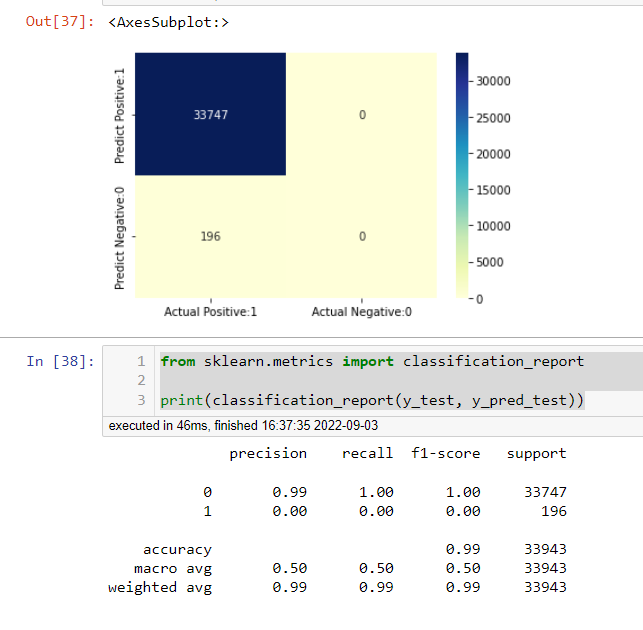

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

In [ ]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting a Pulsar Star classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [ ]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred_test)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

In [ ]:
# calculate cross-validated ROC AUC 

from sklearn.model_selection import cross_val_score

Cross_validated_ROC_AUC = cross_val_score(linear_svc, X_train, y_train, cv=10, scoring='roc_auc').mean()

print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

In [ ]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV


# import SVC classifier
from sklearn.svm import SVC


# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC() 
declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]




grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)

In [ ]:
# examine the best model


# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [ ]:
# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

# NGBoost

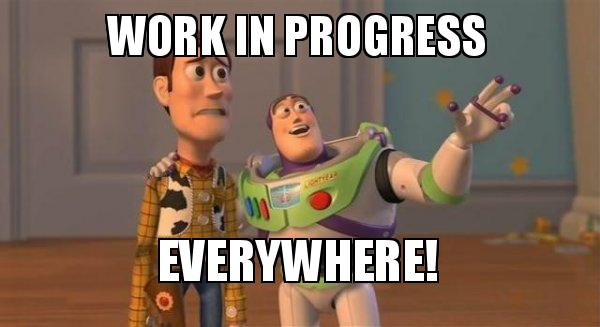

# 6. Logistic regression

#just in case

In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
credit_card = pd.read_csv('SC_data_try4.csv')


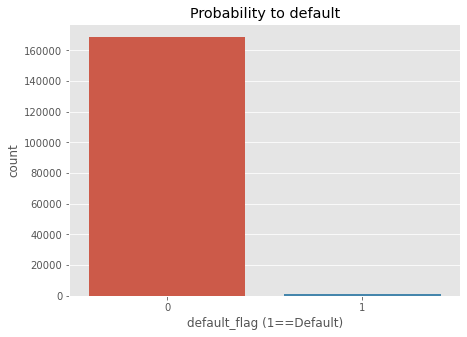

In [88]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='default_flag', data=credit_card)
_ = plt.title('Probability to default')
_ = plt.xlabel('default_flag (1==Default)')

In [89]:
base_line_accuracy = 1-np.sum(credit_card.default_flag)/credit_card.shape[0]
base_line_accuracy

0.994

In [90]:
X = credit_card.drop(columns='default_flag', axis=1)
y = credit_card.default_flag.values

<AxesSubplot:>

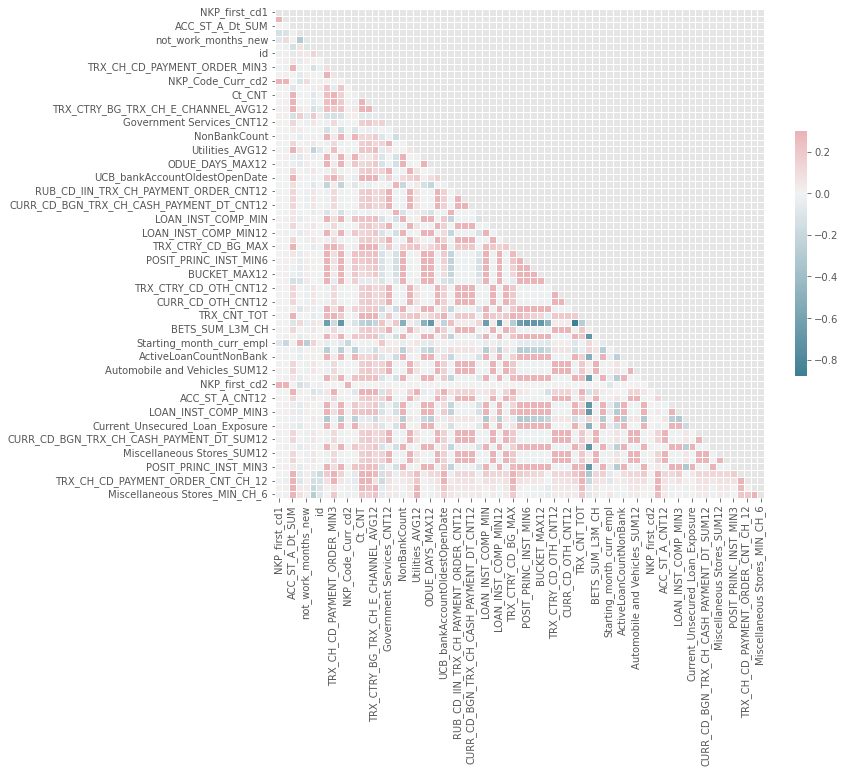

In [91]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [92]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

In [94]:
model1.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [95]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100
print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
print('Training accuracy: %.4f %%' % train_accuracy)
print('Training AUC: %.4f %%' % train_auc_roc)

Confusion matrix:
 [[126562      0]
 [   722      0]]
Training accuracy: 99.4328 %
Training AUC: 79.2041 %


In [96]:
y_test_hat = model1.predict(X_test)
y_test_hat_probs = model1.predict_proba(X_test)[:,1]
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100
print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
print('Training accuracy: %.4f %%' % test_accuracy)
print('Training AUC: %.4f %%' % test_auc_roc)

Confusion matrix:
 [[42195     0]
 [  234     0]]
Training accuracy: 99.4485 %
Training AUC: 74.7330 %


In [97]:
print(classification_report(y_test, y_test_hat, digits=6))

              precision    recall  f1-score   support

           0   0.994485  1.000000  0.997235     42195
           1   0.000000  0.000000  0.000000       234

    accuracy                       0.994485     42429
   macro avg   0.497242  0.500000  0.498617     42429
weighted avg   0.989000  0.994485  0.991735     42429



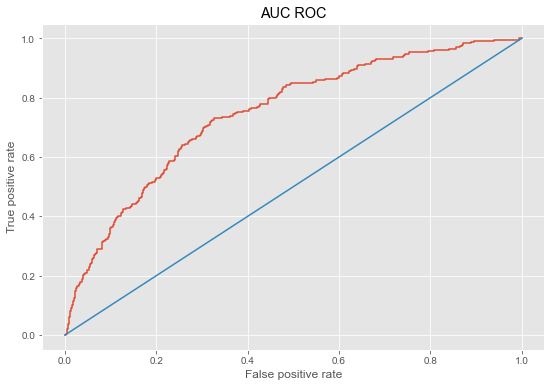

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

In [99]:
y_hat_90 = (y_test_hat_probs > 0.90 )*1
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_90))
print(classification_report(y_test, y_hat_90, digits=6))

Confusion matrix:
 [[42195     0]
 [  234     0]]
              precision    recall  f1-score   support

           0   0.994485  1.000000  0.997235     42195
           1   0.000000  0.000000  0.000000       234

    accuracy                       0.994485     42429
   macro avg   0.497242  0.500000  0.498617     42429
weighted avg   0.989000  0.994485  0.991735     42429



In [100]:
y_hat_10 = (y_test_hat_probs > 0.10)*1
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_10))
print(classification_report(y_test, y_hat_10, digits=4))

Confusion matrix:
 [[42168    27]
 [  234     0]]
              precision    recall  f1-score   support

           0     0.9945    0.9994    0.9969     42195
           1     0.0000    0.0000    0.0000       234

    accuracy                         0.9938     42429
   macro avg     0.4972    0.4997    0.4985     42429
weighted avg     0.9890    0.9938    0.9914     42429

